In [ ]:
import os
import re
import nltk
import spacy
import numpy as np
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM, GRU, Bidirectional

nltk.download('punkt_tab')
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')

nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))
stop_words = [i for i in stop_words if i not in ['not','until','against','up', 'down', 'no', 'nor',"aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",
                                                 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "don't"]]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv("dataset.csv")
df=df.sample(frac=1)
df=df.head(10000)
df.head()

,Unnamed: 0,content,label
17823,17823,I dont know if the mean comments really stopp...,0
10088,10088,omg dude i'm sorry! that really sucks! wear pa...,0
6222,6222,yes.. flickr upload photo its sucks on eventbo...,1
19632,19632,If you saw your zipper was down and people ha...,0
16511,16511,Why thank you<3 I'd like to be your stud ;D,0


**1) DATA CLEANING**

In [ ]:
def get_word_len(content):
  return len(content.split(' '))

def get_char_len(content):
  return len(content);

def preprocess_data(content):
  content=content.lower()
  #Using regex to clean the content
  content=re.sub(r"http\S+|www\S+|https\S+", '', content, flags=re.MULTILINE)  #Remove links
  content=re.sub(r'@\w+', '', content) #Remove any mentions e.g- @username
  content=re.sub(r'[^\w\s#]', '', content)
  #Creating tokens
  tokens=[token.lemma_ for token in nlp(content)]
  tokens=[token for token in tokens if token not in stop_words]
  tokens=[token for token in tokens if len(token)>1]
  processed_cotent=" ".join(tokens)
  return processed_cotent

df["clean_content"]=[preprocess_data(cont) for cont in tqdm(df["content"],position=0,leave=True)]  #tqdm used for show the progress of processing
df["content_word_len"]=df["clean_content"].apply(get_word_len)
df["content_char_len"]=df["clean_content"].apply(get_char_len)

df.head()

100%|██████████| 10000/10000 [01:59<00:00, 83.36it/s]


,Unnamed: 0,content,label,clean_content,content_word_len,content_char_len
17823,17823,I dont know if the mean comments really stopp...,0,not know mean comment really stop think stop r...,15,90
10088,10088,omg dude i'm sorry! that really sucks! wear pa...,0,omg dude sorry really suck wear pant opaque ti...,16,88
6222,6222,yes.. flickr upload photo its sucks on eventbo...,1,yes flickr upload photo suck eventbox huhuhu t...,15,84
19632,19632,If you saw your zipper was down and people ha...,0,see zipper down people notice would,6,35
16511,16511,Why thank you<3 I'd like to be your stud ;D,0,thank you3 like stud,7,23


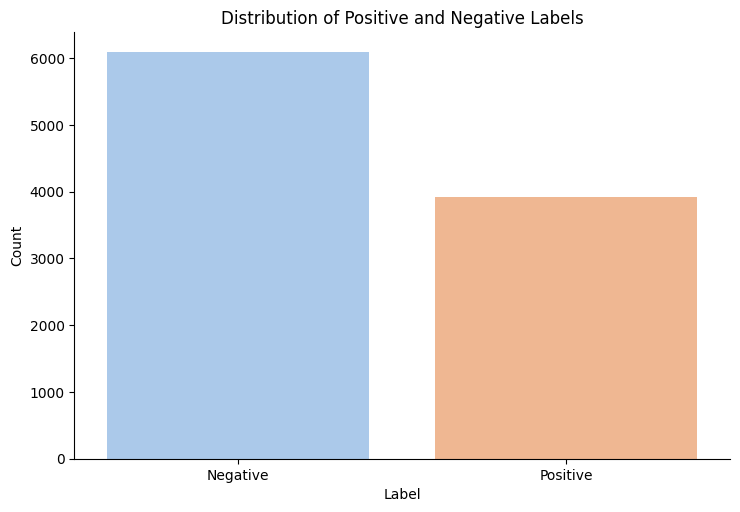

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df['label_name'] = df['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')


sns.catplot(x='label_name', kind='count', data=df, height=5, aspect=1.5, palette='pastel')

plt.title('Distribution of Positive and Negative Labels')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

In [ ]:
epochs_ = 10
seq_len = 20
batch_size_ = 64
training_size = .8
embedding_len = 100

# Basically here the total data is divided into 80% in trianing, 20% in testing and the test one is further divided into validation (50%) and testing (50%)
x_train, x_test, y_train, y_test = train_test_split(df['clean_content'], df['label'], test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

fig = px.pie(values=[len(x_train), len(x_test), len(x_val)], title='Distribution of Training,Testing and Validation Tweets' ,
             names= ['Training', 'Testing','Validation'], hover_name = ['Training', 'Testing','Validation'] , opacity = .9, template = 'simple_white')
fig.show()

In [ ]:
# Using One hot coding changing the text to a vector.
vec = CountVectorizer(binary = True)
vec = vec.fit(df['clean_content'])



enc_tweets = vec.transform(df['clean_content']).toarray()

x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['label'], test_size = training_size, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)



# Building out first neural network :)
model = Sequential()

# This is a linear stack of layers we create model by adding layers sequentially and tunning the value where it gave the best result :)
model.add(Dense(2048, activation='relu', input_shape=(enc_tweets.shape[1],)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

history_1 = model.fit(x_train, y_train, epochs = epochs_, batch_size = batch_size_, validation_data=(x_val, y_val))
print('\n')
print("Model Evaluation on Testing Data : ", round(model.evaluate(x_test,y_test)[1]*100,2))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 807ms/step - accuracy: 0.5402 - loss: 0.6909 - val_accuracy: 0.6012 - val_loss: 0.6825
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 706ms/step - accuracy: 0.6189 - loss: 0.6737 - val_accuracy: 0.6012 - val_loss: 0.6733
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 881ms/step - accuracy: 0.6224 - loss: 0.6608 - val_accuracy: 0.6012 - val_loss: 0.6652
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 718ms/step - accuracy: 0.6272 - loss: 0.6328 - val_accuracy: 0.6018 - val_loss: 0.6525
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 915ms/step - accuracy: 0.6486 - loss: 0.5954 - val_accuracy: 0.6332 - val_loss: 0.6315
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 884ms/step - accuracy: 0.7422 - loss: 0.5126 - val_accuracy: 0.6920 - val_loss: 0.5954
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 867ms/step - accuracy: 0.8612 - loss: 0.4210 - val_accuracy: 0.7050 - val_loss: 0.5892
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 686ms/step - accuracy: 0.9320 - loss: 0.2949 - val_accu

In [ ]:
# Using Text Encoding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_content'])

word_index = tokenizer.word_index
index_word = tokenizer.index_word

sequences = tokenizer.texts_to_sequences(df['clean_content'])
enc_tweets = pad_sequences(sequences, maxlen = seq_len, padding = 'post')

x_train, x_test, y_train, y_test = train_test_split(enc_tweets, df['label'], test_size = training_size, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)

model = Sequential()

model.add(Dense(64, activation='relu', input_shape=(seq_len,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics=['accuracy'])

history_4 = model.fit(x_train, y_train, epochs = epochs_, batch_size = batch_size_, validation_data=(x_val, y_val))
print('\n')
print("Model Evaluation on Testing Data : ", round(model.evaluate(x_test,y_test)[1]*100,2))

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4009 - loss: 387.0917 - val_accuracy: 0.4250 - val_loss: 269.4190
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4534 - loss: 225.6019 - val_accuracy: 0.4975 - val_loss: 181.7072
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5316 - loss: 160.6781 - val_accuracy: 0.5173 - val_loss: 148.6796
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5399 - loss: 143.4399 - val_accuracy: 0.5260 - val_loss: 129.0595
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5536 - loss: 119.6328 - val_accuracy: 0.5268 - val_loss: 111.7635
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5716 - loss: 98.7866 - val_accuracy: 0.5088 - val_loss: 98.7250
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5611 - loss: 82.7342 - val_accuracy: 0.5355 - val_loss: 87.7464
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5589 - loss: 78.6168 - val_ac